In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume,date,time
0,2023-11-01 00:00:00,34618.86,34676.51,34656.38,34667.88,48.953000,2023-11-01,00:00:00
1,2023-11-01 00:01:00,34642.54,34687.53,34673.30,34642.82,16.178075,2023-11-01,00:01:00
2,2023-11-01 00:02:00,34637.97,34656.82,34642.53,34656.56,8.753120,2023-11-01,00:02:00
3,2023-11-01 00:03:00,34617.22,34656.56,34656.56,34629.34,11.308610,2023-11-01,00:03:00
4,2023-11-01 00:04:00,34597.99,34630.42,34629.41,34622.27,8.583808,2023-11-01,00:04:00
...,...,...,...,...,...,...,...,...
528627,2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,2024-10-31,23:56:00
528628,2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,2024-10-31,23:57:00
528629,2024-10-31 23:58:00,70193.97,70242.25,70232.55,70207.78,9.589688,2024-10-31,23:58:00
528630,2024-10-31 23:59:00,70175.16,70207.79,70207.79,70197.83,7.112237,2024-10-31,23:59:00


### 1. Calculate Technical Indicators

Calculate the values and add new columns with calculated values for **RSI**, **MACD**, **Moving Averages** and other relevant indicators.

#### 2.3.1. Relative Strength Index (RSI)

**RSI** is a momentum oscillator that measures the speed and change of recent price movements. It is used to identify overbought or oversold conditions in a stock's price, generally over a 14-day period.

- **Formula**: The RSI is calculated as:
  
  $$\text{RSI} = 100 - \frac{100}{1 + RS}$$
  
  where $RS$ (Relative Strength) is the ratio of **average gains** to **average losses** over the lookback period (e.g., 14 days).

- **Interpretation**:
  - **Overbought Condition**: When RSI is above 70, the asset is often considered overbought, suggesting a potential for a pullback.
  - **Oversold Condition**: When RSI is below 30, the asset is considered oversold, suggesting a potential for a rebound.

- **Calculation**:
  - Calculate the **change** in price from one day to the next.
  - Separate the changes into **gains** (positive changes) and **losses** (negative changes).
  - Compute the **average gain** and **average loss** over the 14-day period.
  - Calculate \( RS \) as the ratio of average gain to average loss.
  - Use the RSI formula to convert \( RS \) into an index between 0 and 100.

In [3]:
def calculate_rsi(data, window=14):
    """
    RSI is a momentum oscillator that measures the speed and change of price movements, typically over a 14-period interval.
    Assuming 'data' is a DataFrame with a 'close' price column

    Parameters
    ----------
    data:   a DataFrame with the time series data. A column with the name 'close' must be present in the DataFrame! 
            This column is used to calculate the 'RSI' value.
    window: the time period that is taken into account when calculating the 'RSI'
    """
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    
    return data

In [4]:
# Calculate RSI
btc_price_data_1_year = calculate_rsi(btc_price_data_1_year)

#### 2.3.2. Moving Average Convergence Divergence (MACD)

**MACD** is a trend-following momentum indicator that shows the relationship between two moving averages of an asset’s price.

- **Formula**:
  - **MACD Line**: $\text{MACD} = \text{EMA}_{\text{short}} - \text{EMA}_{\text{long}}$
  - **Signal Line**: A **9-day EMA** of the MACD line.
  - **MACD Histogram**: The difference between the MACD line and the Signal Line.

  Here, EMA stands for Exponential Moving Average, which gives more weight to recent prices.

- **Common Parameters**:
  - **Short EMA**: Often set to a 12-day EMA.
  - **Long EMA**: Often set to a 26-day EMA.
  - **Signal Line EMA**: Often set to a 9-day EMA of the MACD line.

- **Interpretation**:
  - **MACD Line Crosses Above Signal Line**: This is a bullish signal, indicating a potential buy.
  - **MACD Line Crosses Below Signal Line**: This is a bearish signal, indicating a potential sell.
  - **MACD Divergence**: If the price and MACD are moving in opposite directions, it may signal a reversal.
  - **Histogram**: The MACD histogram shows the distance between the MACD line and the Signal Line. When the histogram grows larger, it indicates a strengthening trend in that direction.

- **Application**:
  - The MACD helps traders see changes in momentum, trend direction, and possible reversal points by analyzing the difference between the short and long EMAs.

In [5]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Moving Average Convergence Divergence (MACD) is calculated using two exponential moving averages (EMA):
    the 12-day EMA and the 26-day EMA, with a 9-day EMA as the signal line.
    """
    data['EMA12'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD Line
    data['MACD'] = data['EMA12'] - data['EMA26']
    
    # Signal Line
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    return data

In [6]:
# Calculate MACD (Moving Average Convergence Divergence)
btc_price_data_1_year = calculate_macd(btc_price_data_1_year)

#### 2.3.3. Moving Averages (SMA and EMA)

Moving averages smooth out price data to help identify trends over specific time frames. They are often used to see the underlying trend of an asset’s price and are among the most widely used technical indicators.

##### 2.2.3.1. Simple Moving Average (SMA)

- **Definition**: The **SMA** is the average of the closing prices over a specific period. For example, a 10-day SMA is the average closing price over the last 10 days.
  
- **Formula**:
  $$\text{SMA} = \frac{\sum_{i=1}^{N} \text{Price}_i}{N}$$
  where $N$ is the period (e.g., 10 days).

- **Interpretation**:
  - **Trend Identification**: When prices are above the SMA, it suggests an upward trend; when below, it suggests a downward trend.
  - **Crossovers**: When a short-term SMA crosses above a long-term SMA (e.g., 10-day SMA crosses above the 50-day SMA), it generates a bullish signal. The reverse crossover indicates a bearish signal.

##### 2.2.3.2. Exponential Moving Average (EMA)

- **Definition**: The **EMA** is a weighted moving average that gives more importance to recent prices, making it more responsive to new information than the SMA.
  
- **Formula**:
  - EMA uses a multiplier:
    $$\text{EMA}_\text{current} = \left(\frac{2}{N+1}\right) \times (\text{Price}_\text{current} - \text{EMA}_\text{previous}) + \text{EMA}_\text{previous}$$
    where $N$ is the number of periods.

- **Interpretation**:
  - **More Sensitive to Price Changes**: Because the EMA responds more quickly to recent prices, it is useful in identifying potential reversals and shorter-term trends.

In [7]:
def calculate_moving_averages(data, sma_window=20, ema_window=20):
    """
    Simple Moving Average (SMA) is the average price over a specified number of periods, 
    while Exponential Moving Average (EMA) gives more weight to recent prices.
    """
    # Simple Moving Average
    data['SMA'] = data['close'].rolling(window=sma_window).mean()
    
    # Exponential Moving Average
    data['EMA'] = data['close'].ewm(span=ema_window, adjust=False).mean()
    
    return data

In [8]:
# Calculate moving averages
btc_price_data_1_year = calculate_moving_averages(btc_price_data_1_year)

### 2. Calculate Target Variable

In [9]:
def create_target_variable(data, threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100

    # Define the target as 1 (buy) if the future return is above the threshold, and 0 (sell) if it is below or equal to the threshold.
    data_copy['target'] = (data_copy['future_return'] > threshold).astype(float)

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    #data_copy = data_copy.dropna()

    # Check the balance of 1s and 0s in our target variable to understand how many “buy” and “sell” signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [10]:
def create_target_variable_with_techn_indicators(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = (
        (data_copy['future_return'] > price_threshold) &
        # (data_copy['RSI'] < 30) &   # buy signal for RSI
        (data_copy['RSI'] < 40) &    # buy signal for RSI
        ((data_copy['MACD'] > data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) <= data_copy['Signal_Line'].shift(1))) & # buy signal for MACD
        ((data_copy['close'] > data_copy['SMA']) & (data_copy['close'].shift(1) <= data_copy['SMA'].shift(1))) # buy signal for SMA
    ).astype(int)

    conditions_sell  = (
        (data_copy['future_return'] < - price_threshold) &
        #(data_copy['RSI'] > 70) &    # sell signal for RSI 
        (data_copy['RSI'] > 60) &     # sell signal for RSI 
        (data_copy['MACD'] < data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) >= data_copy['Signal_Line'].shift(1)) & # sell signal for MACD 
        (data_copy['close'] < data_copy['SMA']) & (data_copy['close'].shift(1) >= data_copy['SMA'].shift(1)) # sell signal for SMA 
    ).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and -1(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = -1 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 1s, 0s and -1s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [11]:
def create_target_variable_with_techn_indicators_hourly(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = (
        (data_copy['future_return'] > price_threshold) &
        #(data_copy['RSI'] < 30) &   # buy signal for RSI
        (data_copy['RSI'] < 40) &    # buy signal for RSI
        ((data_copy['MACD'] > data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) <= data_copy['Signal_Line'].shift(1))) #& # buy signal for MACD
        # ((data_copy['close'] > data_copy['SMA']) & (data_copy['close'].shift(1) <= data_copy['SMA'].shift(1))) # buy signal for SMA
    ).astype(int)

    conditions_sell  = (
        (data_copy['future_return'] < - price_threshold) &
        #(data_copy['RSI'] > 70) &    # sell signal for RSI 
        (data_copy['RSI'] > 60) &     # sell signal for RSI 
        (data_copy['MACD'] < data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) >= data_copy['Signal_Line'].shift(1)) #& # sell signal for MACD 
        # (data_copy['close'] < data_copy['SMA']) & (data_copy['close'].shift(1) >= data_copy['SMA'].shift(1)) # sell signal for SMA 
    ).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and -1(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = -1 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 1s, 0s and -1s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [12]:
# Define the threshold for the price change to classify as 'buy' or 'sell'. For instance, if we want a 1% increase to be a 'buy' signal,
# the threshold will be 0.01.
threshold = 0.01

# Compute the 'target' variable
btc_price_data_1_year = create_target_variable_with_techn_indicators(btc_price_data_1_year, threshold)

target
 0    528514
 1        65
-1        53
Name: count, dtype: int64


In [13]:
# btc_price_data_1_year_resampled = create_target_variable_with_techn_indicators_hourly(btc_price_data_1_year_resampled, 0.01)

## 3. Backtesting

count buy: 1
Buy signal balance: 1000
Buy signal position: 0.028501404691730233
--------------------------------
count sell: 2
Sell signal position: 0.028501404691730233
Sell signal balance: 1039.0420791888728
--------------------------------
count buy: 3
Buy signal balance: 1039.0420791888728
Buy signal position: 0.0282903050189127
--------------------------------
count sell: 4
Sell signal position: 0.0282903050189127
Sell signal balance: 1021.7550054040161
--------------------------------
count buy: 5
Buy signal balance: 1021.7550054040161
Buy signal position: 0.023469214201590455
--------------------------------
count sell: 6
Sell signal position: 0.023469214201590455
Sell signal balance: 1028.7974125094872
--------------------------------
count buy: 7
Buy signal balance: 1028.7974125094872
Buy signal position: 0.02515977186205737
--------------------------------
count sell: 8
Sell signal position: 0.02515977186205737
Sell signal balance: 1102.2979120387085
-------------------------

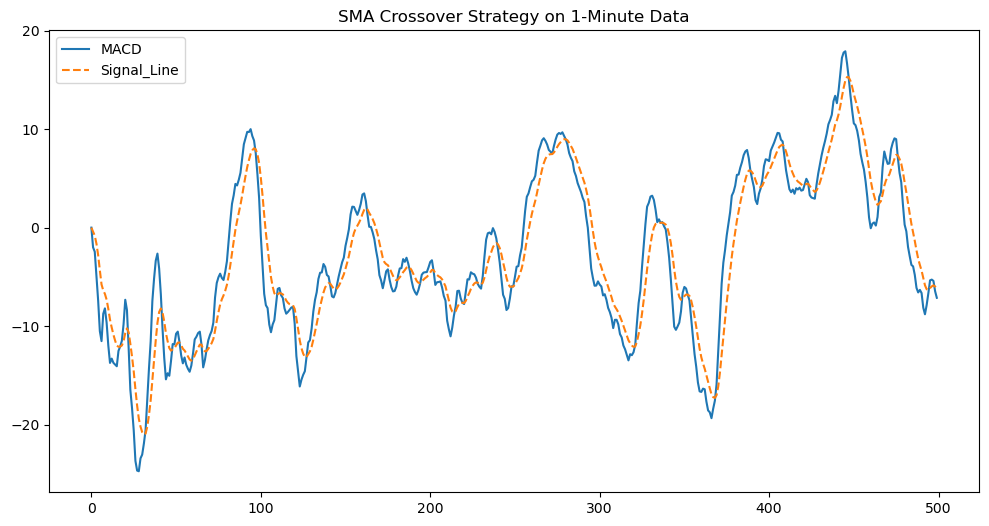

In [24]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# Load your Bitcoin dataset (assume columns: 'timestamp', 'close', 'high', 'low', 'volume')
# df = pd.read_csv('bitcoin_price.csv')
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True)

df = btc_price_data_1_year

# # Resample the data to different timeframes
# def resample_data(data, timeframe='15T'):
#     return data.resample(timeframe).mean()

    # return data.resample(timeframe).agg({
    #     'close': 'last', 
    #     'high': 'max', 
    #     'low': 'min', 
    #     'volume': 'sum'
    # }).dropna()

# # Apply a simple moving average crossover strategy
# def sma_crossover_strategy(data, short_window=10, long_window=50):
#     data['SMA_short'] = data['close'].rolling(window=short_window).mean()
#     data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    
#     # Generate signals
#     data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
#     data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
#     return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    count = 0
    for i in range(1, len(data)):
        # print("target: ", data.target)
        if data['target'].iloc[i] == 1 and balance > 0:  # Buy signal
            count = count + 1
            print("count buy:", count)
            
            print("Buy signal balance:", balance)
            position = balance / data['close'].iloc[i]
            print("Buy signal position:", position)
            print("--------------------------------")
            balance = 0
        elif data['target'].iloc[i] == -1 and position > 0:  # Sell signal
            count = count + 1
            print("count sell:", count)
            
            print("Sell signal position:", position)
            balance = position * data['close'].iloc[i]
            print("Sell signal balance:", balance)
            print("--------------------------------")
            position = 0
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    print("final_balance after:", final_balance)
    return final_balance

# Test on multiple timeframes
timeframes = [ '1h']
# timeframes = ['1min', '5min', '15min', '1h', '4h', '1D']
results = {}

for timeframe in timeframes:
    # df_resampled = resample_data(df, timeframe)
    # df_strategy = sma_crossover_strategy(df_resampled)
    # final_balance = backtest(df_strategy)
    # print(df_resampled.shape)
    # Compute the 'target' variable
    # df_strategy = create_target_variable_with_techn_indicators(df_resampled, threshold)
    final_balance = backtest(df)
    results[timeframe] = final_balance

# Print results
for timeframe, balance in results.items():
    print(f"Final Balance with {timeframe} data: ${balance:.2f}")
    final_return = ((balance - 1000) / 1000) * 100
    print(f"Final Return with {timeframe} data: ${final_return:.2f}[%]")

# Visualize a selected timeframe (e.g., 15-minute data)
# df_strategy = sma_crossover_strategy(resample_data(df, '15T'))
# df_strategy = resample_data(df, '1h')
plt.figure(figsize=(12, 6))
# plt.plot(df_strategy['close'], label='Close Price')
plt.plot(df['MACD'][:500], label='MACD', linestyle='-')
plt.plot(df['Signal_Line'][:500], label='Signal_Line', linestyle='--')
plt.legend()
plt.title('SMA Crossover Strategy on 1-Minute Data')
plt.show()

In [ ]:
df = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
df

Here's a sample code to test your Bitcoin trading strategy on different timeframes using Python. This example includes resampling, applying a simple moving average (SMA) crossover strategy, and backtesting it.

---

### **Sample Code for Strategy Testing**

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your Bitcoin dataset (assume columns: 'timestamp', 'close', 'high', 'low', 'volume')
df = pd.read_csv('bitcoin_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample the data to different timeframes
def resample_data(data, timeframe='15T'):
    return data.resample(timeframe).agg({
        'close': 'last', 
        'high': 'max', 
        'low': 'min', 
        'volume': 'sum'
    }).dropna()

# Apply a simple moving average crossover strategy
def sma_crossover_strategy(data, short_window=10, long_window=50):
    data['SMA_short'] = data['close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    
    # Generate signals
    data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
    return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1:  # Buy signal
            position = balance / data['close'].iloc[i]
            balance = 0
        elif data['signal'].iloc[i] == -1:  # Sell signal
            balance = position * data['close'].iloc[i]
            position = 0
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    return final_balance

# Test on multiple timeframes
timeframes = ['5T', '15T', '1H', '4H']
results = {}

for timeframe in timeframes:
    df_resampled = resample_data(df, timeframe)
    df_strategy = sma_crossover_strategy(df_resampled)
    final_balance = backtest(df_strategy)
    results[timeframe] = final_balance

# Print results
for timeframe, balance in results.items():
    print(f"Final Balance with {timeframe} data: ${balance:.2f}")

# Visualize a selected timeframe (e.g., 15-minute data)
df_strategy = sma_crossover_strategy(resample_data(df, '15T'))
plt.figure(figsize=(12, 6))
plt.plot(df_strategy['close'], label='Close Price')
plt.plot(df_strategy['SMA_short'], label='SMA Short', linestyle='--')
plt.plot(df_strategy['SMA_long'], label='SMA Long', linestyle='--')
plt.legend()
plt.title('SMA Crossover Strategy on 15-Minute Data')
plt.show()
```

---

### **How It Works**
1. **Resampling**:
   - The `resample_data` function aggregates minutely data into higher timeframes (e.g., 15T = 15 minutes).

2. **SMA Crossover Strategy**:
   - A simple strategy where a **short-term SMA** crossing above a **long-term SMA** triggers a **buy**, and the reverse triggers a **sell**.

3. **Backtesting**:
   - Simulates portfolio performance using signals generated by the strategy.

4. **Multi-Timeframe Testing**:
   - Evaluates the strategy on multiple timeframes (e.g., 5T, 15T, 1H, 4H).

---

### **Next Steps**
- Adjust parameters (e.g., SMA window sizes) to fit your strategy.
- Expand the strategy with more features (e.g., RSI, MACD).
- Use metrics like **Sharpe ratio** and **drawdown** to assess risk-adjusted returns.

Would you like to enhance this strategy further or explore advanced techniques?

In [ ]:
df = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
df

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# Load your Bitcoin dataset (assume columns: 'timestamp', 'close', 'high', 'low', 'volume')
# df = pd.read_csv('bitcoin_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample the data to different timeframes
def resample_data(data, timeframe='15T'):
    return data.resample(timeframe).agg({
        'close': 'last', 
        'high': 'max', 
        'low': 'min', 
        'volume': 'sum'
    }).dropna()

# Apply a simple moving average crossover strategy
def sma_crossover_strategy(data, short_window=10, long_window=50):
    data['SMA_short'] = data['close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    
    # Generate signals
    data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
    return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1:  # Buy signal
            position = balance / data['close'].iloc[i]
            balance = 0
        elif data['signal'].iloc[i] == -1:  # Sell signal
            balance = position * data['close'].iloc[i]
            position = 0
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    return final_balance

# Test on multiple timeframes
timeframes = ['1min', '5min', '15min', '1h', '4h', '1D']
results = {}

for timeframe in timeframes:
    df_resampled = resample_data(df, timeframe)
    df_strategy = sma_crossover_strategy(df_resampled)
    final_balance = backtest(df_strategy)
    results[timeframe] = final_balance

# Print results
for timeframe, balance in results.items():
    print(f"Final Balance with {timeframe} data: ${balance:.2f}")

# Visualize a selected timeframe (e.g., 15-minute data)
df_strategy = sma_crossover_strategy(resample_data(df, '15T'))
plt.figure(figsize=(12, 6))
plt.plot(df_strategy['close'], label='Close Price')
plt.plot(df_strategy['SMA_short'], label='SMA Short', linestyle='--')
plt.plot(df_strategy['SMA_long'], label='SMA Long', linestyle='--')
plt.legend()
plt.title('SMA Crossover Strategy on 15-Minute Data')
plt.show()

In [ ]:
df_strategy.signal.value_counts()

In [ ]:
df_strategy[df_strategy['signal'] == 1]

Here's an expanded version of the strategy that includes **RSI** and **MACD** indicators along with the SMA crossover strategy. These indicators help refine entry and exit points, improving the overall performance of the strategy.

---

### **Updated Strategy: SMA, RSI, and MACD**

#### **Steps Added**
1. **RSI (Relative Strength Index)**:
   - Used to identify overbought and oversold conditions (e.g., buy when RSI < 30, sell when RSI > 70).

2. **MACD (Moving Average Convergence Divergence)**:
   - A momentum indicator that uses the difference between two EMAs (12, 26) and a signal line (9-period EMA).

---

### **Python Code**

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your Bitcoin dataset
df = pd.read_csv('bitcoin_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample the data to different timeframes
def resample_data(data, timeframe='15T'):
    return data.resample(timeframe).agg({
        'close': 'last', 
        'high': 'max', 
        'low': 'min', 
        'volume': 'sum'
    }).dropna()

# Add SMA, RSI, and MACD to the dataset
def add_indicators(data, short_sma=10, long_sma=50, rsi_period=14, macd_fast=12, macd_slow=26, macd_signal=9):
    # SMA
    data['SMA_short'] = data['close'].rolling(window=short_sma).mean()
    data['SMA_long'] = data['close'].rolling(window=long_sma).mean()
    
    # RSI
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=rsi_period).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema_fast = data['close'].ewm(span=macd_fast, adjust=False).mean()
    ema_slow = data['close'].ewm(span=macd_slow, adjust=False).mean()
    data['MACD'] = ema_fast - ema_slow
    data['MACD_signal'] = data['MACD'].ewm(span=macd_signal, adjust=False).mean()
    
    return data

# Generate trading signals using SMA, RSI, and MACD
def generate_signals(data):
    data['signal'] = 0
    
    # SMA Crossover
    data.loc[data['SMA_short'] > data['SMA_long'], 'signal'] = 1  # Buy
    data.loc[data['SMA_short'] < data['SMA_long'], 'signal'] = -1  # Sell
    
    # RSI Filter
    data.loc[data['RSI'] > 70, 'signal'] = -1  # Overbought -> Sell
    data.loc[data['RSI'] < 30, 'signal'] = 1   # Oversold -> Buy
    
    # MACD Confirmation
    data.loc[(data['MACD'] > data['MACD_signal']) & (data['signal'] == 1), 'signal'] = 1  # Buy confirmed
    data.loc[(data['MACD'] < data['MACD_signal']) & (data['signal'] == -1), 'signal'] = -1  # Sell confirmed
    
    data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
    return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1:  # Buy signal
            position = balance / data['close'].iloc[i]
            balance = 0
        elif data['signal'].iloc[i] == -1:  # Sell signal
            balance = position * data['close'].iloc[i]
            position = 0
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    return final_balance

# Test the strategy on a specific timeframe
timeframe = '15T'
df_resampled = resample_data(df, timeframe)
df_with_indicators = add_indicators(df_resampled)
df_with_signals = generate_signals(df_with_indicators)
final_balance = backtest(df_with_signals)

# Print result
print(f"Final Balance with {timeframe} data: ${final_balance:.2f}")

# Visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(df_with_signals['close'], label='Close Price')
plt.plot(df_with_signals['SMA_short'], label='SMA Short', linestyle='--')
plt.plot(df_with_signals['SMA_long'], label='SMA Long', linestyle='--')
plt.scatter(df_with_signals[df_with_signals['signal'] == 1].index, 
            df_with_signals[df_with_signals['signal'] == 1]['close'], 
            label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(df_with_signals[df_with_signals['signal'] == -1].index, 
            df_with_signals[df_with_signals['signal'] == -1]['close'], 
            label='Sell Signal', marker='v', color='red', alpha=1)
plt.legend()
plt.title('SMA + RSI + MACD Strategy on 15-Minute Data')
plt.show()
```

---

### **How It Works**
1. **Indicators**:
   - **SMA**: Identifies long-term trends.
   - **RSI**: Filters overbought/oversold conditions.
   - **MACD**: Confirms momentum and trend changes.

2. **Signal Generation**:
   - Combines SMA crossover signals with RSI and MACD for more reliable entries/exits.

3. **Backtesting**:
   - Tracks portfolio performance using a simple buy/sell logic.

---

### **Next Steps**
- **Optimize Parameters**: Test different RSI periods, MACD settings, and SMA windows.
- **Performance Metrics**: Evaluate using Sharpe ratio, max drawdown, and win rate.
- **Add More Features**: Include volume or other technical indicators for richer signals.

Would you like assistance optimizing the parameters or testing this on your data?

In [ ]:
df = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your Bitcoin dataset
# df = pd.read_csv('bitcoin_price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample the data to different timeframes
def resample_data(data, timeframe='15T'):
    return data.resample(timeframe).agg({
        'close': 'last', 
        'high': 'max', 
        'low': 'min', 
        'volume': 'sum'
    }).dropna()

# Add SMA, RSI, and MACD to the dataset
def add_indicators(data, short_sma=10, long_sma=50, rsi_period=14, macd_fast=12, macd_slow=26, macd_signal=9):
    # SMA
    data['SMA_short'] = data['close'].rolling(window=short_sma).mean()
    data['SMA_long'] = data['close'].rolling(window=long_sma).mean()
    
    # RSI
    delta = data['close'].diff(1)
    # gain = np.where(delta > 0, delta, 0)
    # loss = np.where(delta < 0, -delta, 0)

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema_fast = data['close'].ewm(span=macd_fast, adjust=False).mean()
    ema_slow = data['close'].ewm(span=macd_slow, adjust=False).mean()
    data['MACD'] = ema_fast - ema_slow
    data['MACD_signal'] = data['MACD'].ewm(span=macd_signal, adjust=False).mean()
    
    return data

# Generate trading signals using SMA, RSI, and MACD
def generate_signals(data):
    data['signal'] = 0
    
    # SMA Crossover
    data.loc[data['SMA_short'] > data['SMA_long'], 'signal'] = 1  # Buy
    data.loc[data['SMA_short'] < data['SMA_long'], 'signal'] = -1  # Sell
    
    # RSI Filter
    data.loc[data['RSI'] > 60, 'signal'] = -1  # Overbought -> Sell
    data.loc[data['RSI'] < 40, 'signal'] = 1   # Oversold -> Buy
    
    # MACD Confirmation
    data.loc[(data['MACD'] > data['MACD_signal']) & (data['signal'] == 1), 'signal'] = 1  # Buy confirmed
    data.loc[(data['MACD'] < data['MACD_signal']) & (data['signal'] == -1), 'signal'] = -1  # Sell confirmed
    
    data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
    return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1:  # Buy signal
            position = balance / data['close'].iloc[i]
            balance = 0
            print("Buy signal - position: ", position)
        elif data['signal'].iloc[i] == -1:  # Sell signal
            balance = position * data['close'].iloc[i]
            position = 0
            print("Sell signal - balance: ", balance)
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    return final_balance

# Test the strategy on a specific timeframe
timeframe = '1h'
df_resampled = resample_data(df, timeframe)
df_with_indicators = add_indicators(df_resampled)
df_with_signals = generate_signals(df_with_indicators)
final_balance = backtest(df_with_signals)

# Print result
print(f"Final Balance with {timeframe} data: ${final_balance:.2f}")

# Visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(df_with_signals['close'], label='Close Price')
plt.plot(df_with_signals['SMA_short'], label='SMA Short', linestyle='--')
plt.plot(df_with_signals['SMA_long'], label='SMA Long', linestyle='--')
plt.scatter(df_with_signals[df_with_signals['signal'] == 1].index, 
            df_with_signals[df_with_signals['signal'] == 1]['close'], 
            label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(df_with_signals[df_with_signals['signal'] == -1].index, 
            df_with_signals[df_with_signals['signal'] == -1]['close'], 
            label='Sell Signal', marker='v', color='red', alpha=1)
plt.legend()
plt.title('SMA + RSI + MACD Strategy on 15-Minute Data')
plt.show()

In [ ]:
df_with_signals[df_with_signals.signal == 1]

In [ ]:
df_with_indicators.RSI.value_counts()


In [ ]:
df_resampled